In [1]:
%matplotlib inline
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [2]:
import simulate
import withdrawal
import market
import harvesting
import metrics

from decimal import Decimal as D
import decimal
import itertools
import pandas
import numpy

In [3]:
def run(market, stock_pct=D('.5'), length=30):
    start_year = market.start_year
    last_year = market.last_year - length
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 2):
        returns = []
        for one_year in zip(range(length), market.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = ((1+annual_returns.stocks) / (1+annual_returns.inflation)) - 1
            bonds = ((1+annual_returns.bonds) / (1+annual_returns.inflation)) - 1
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.pwa(100, 0, returns))
        swrs.loc[start_year+_] = swr
    return swrs

In [4]:
def plot(swrs, title):
    plt.figure(figsize=(20,10)) 
    ax = seaborn.lineplot(
                    data=swrs,
                   )
    min = swrs['SWR'].min()
    seaborn.despine(ax=ax, left=True, bottom=True, offset=20)
    ax.set_title(f'SWR in {title}. Min = {min:.1f}')

/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' in

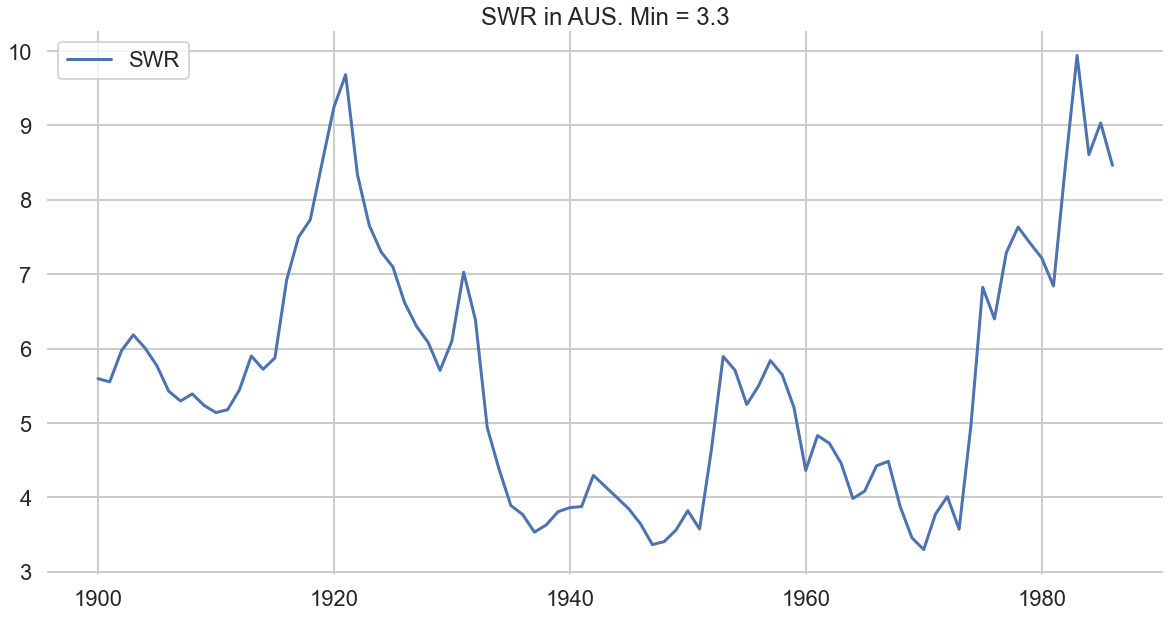

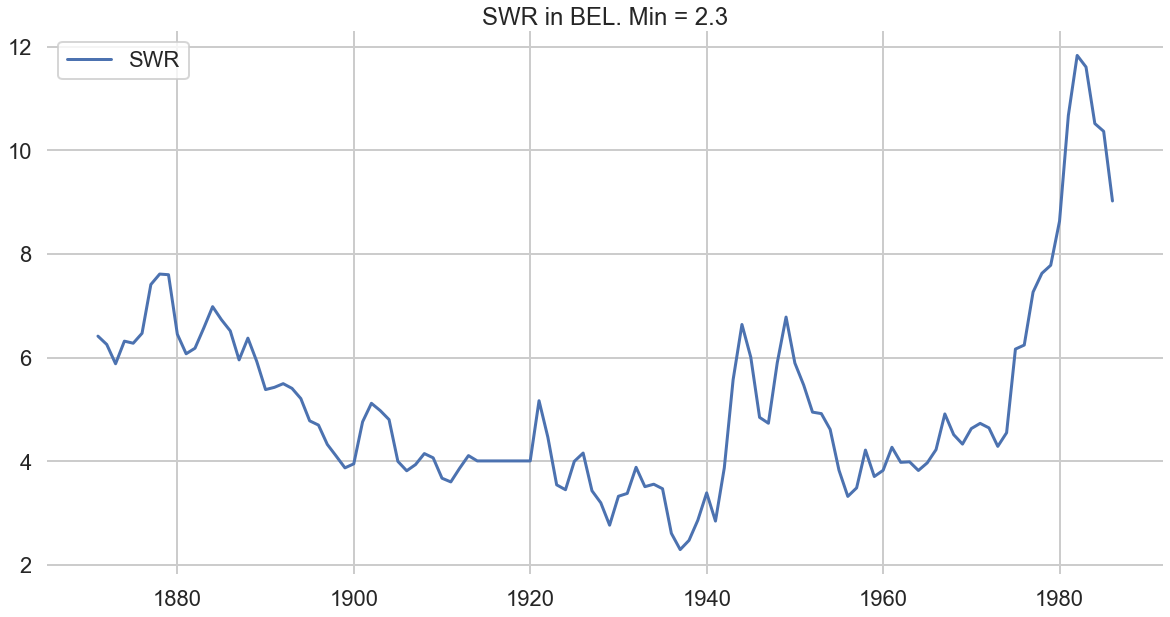

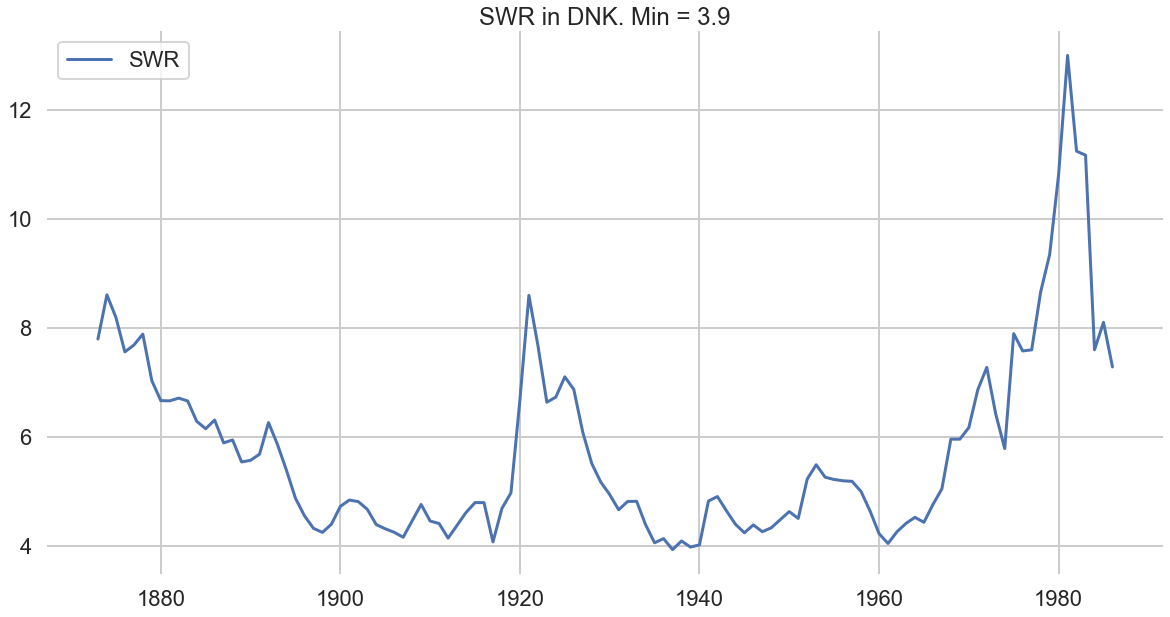

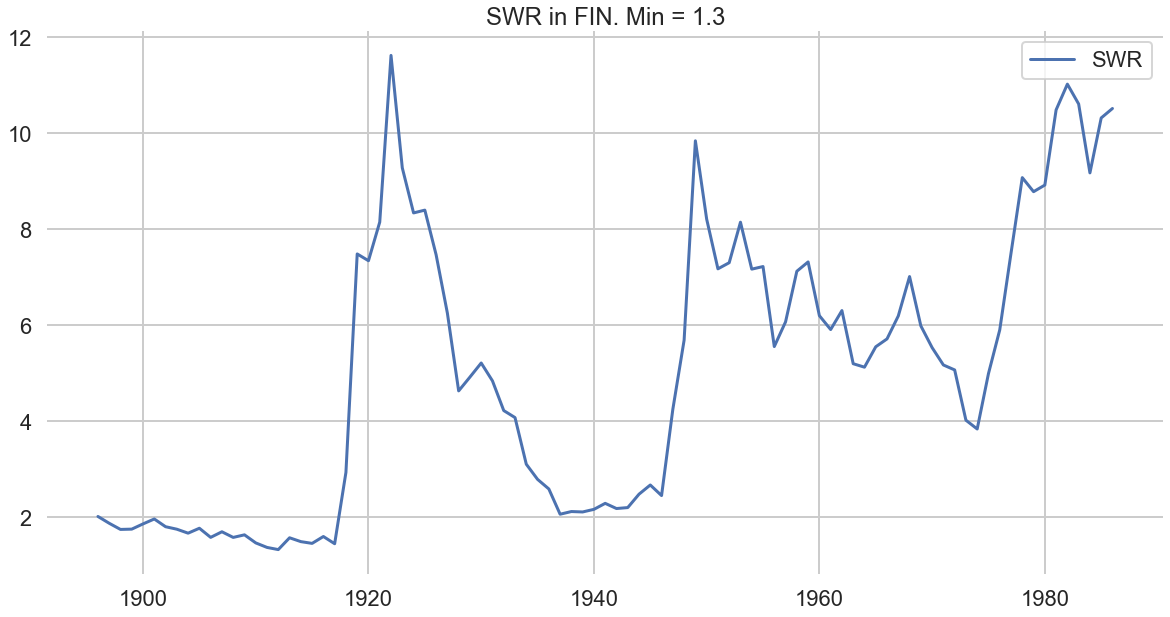

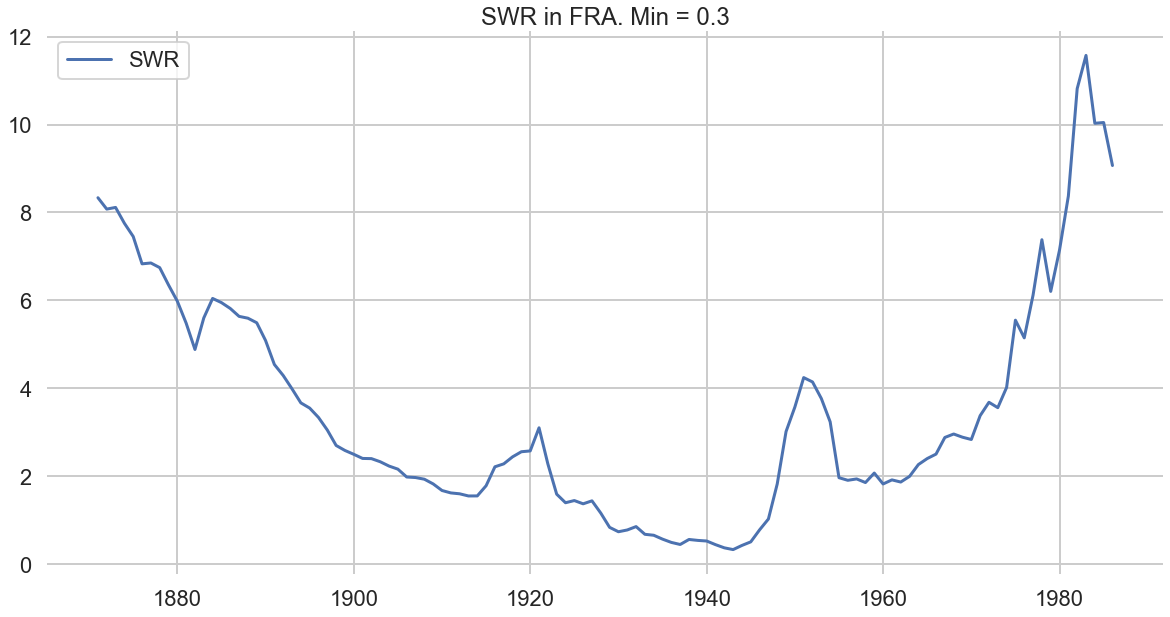

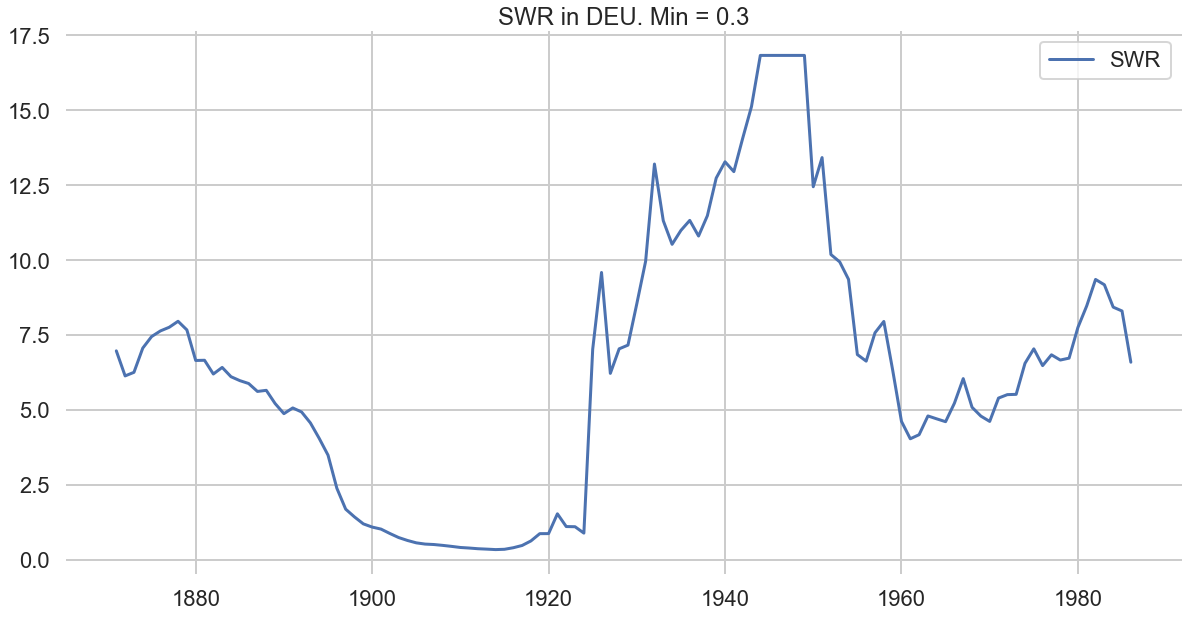

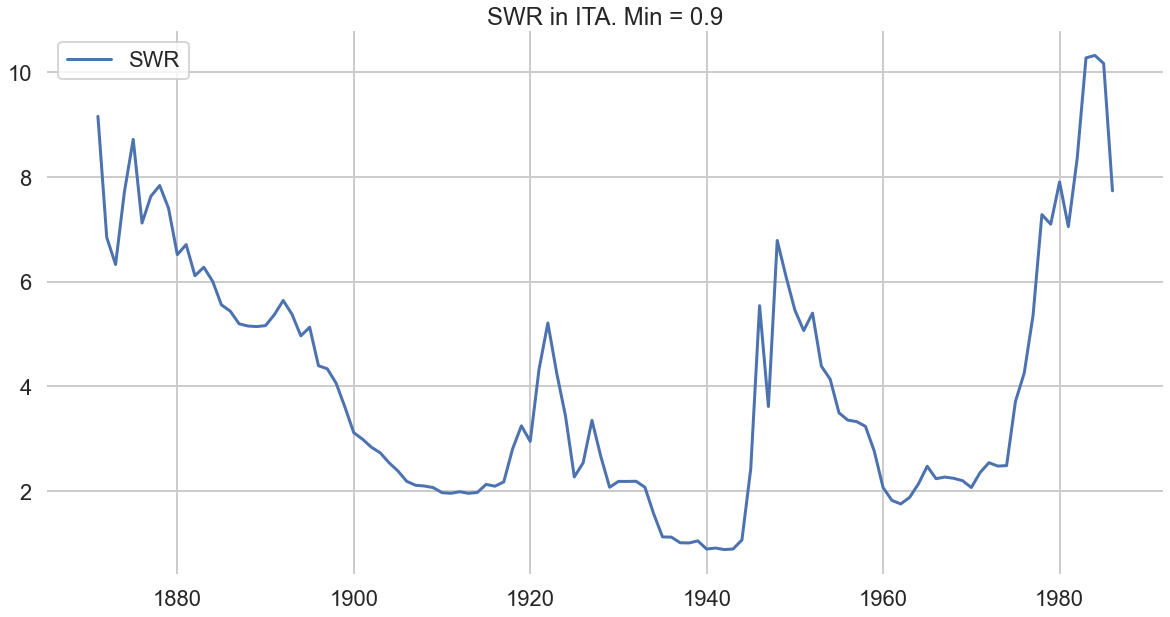

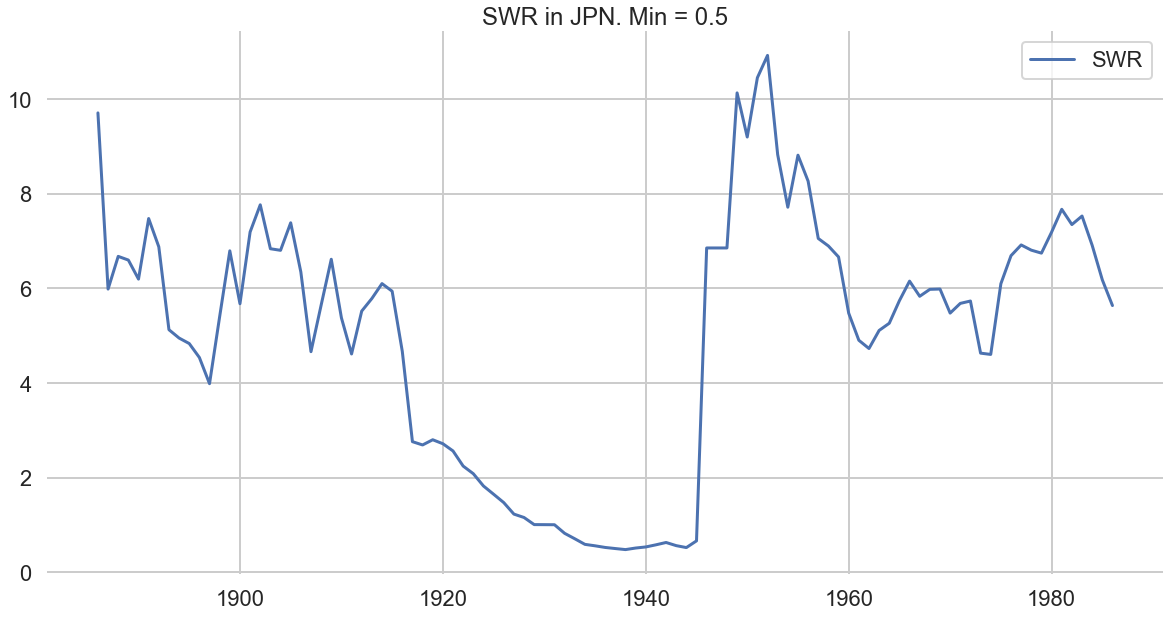

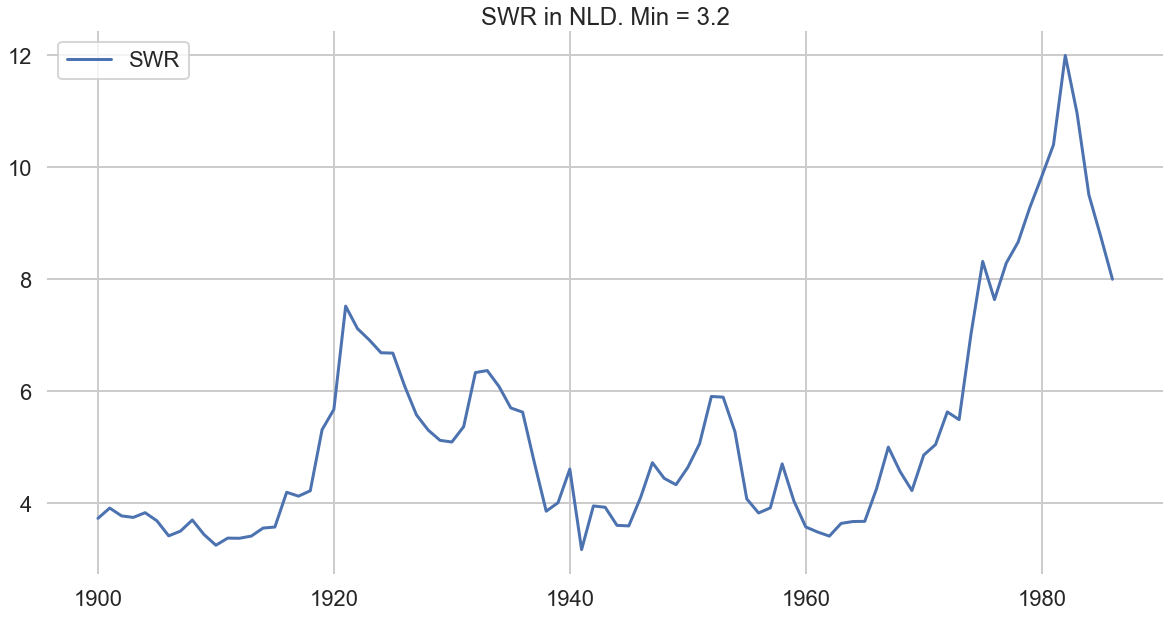

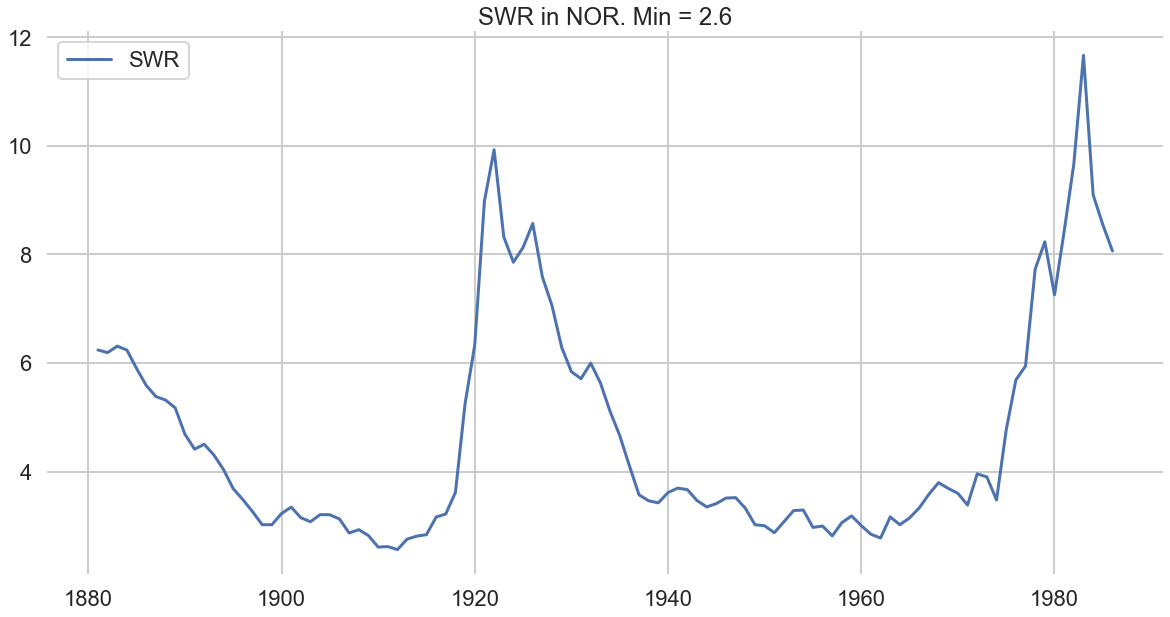

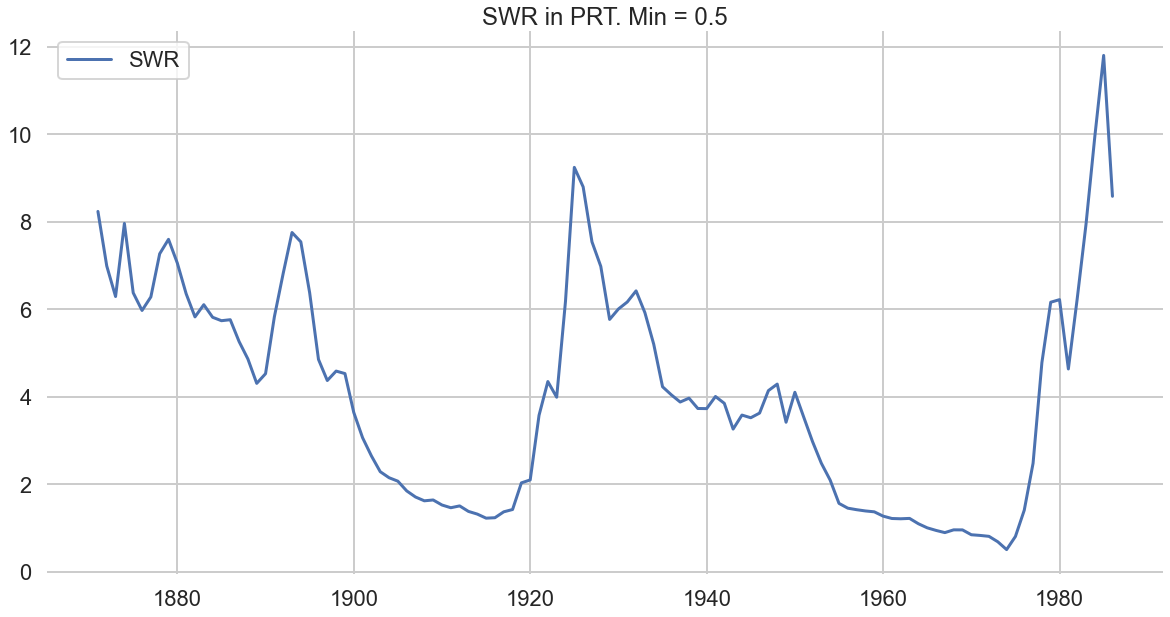

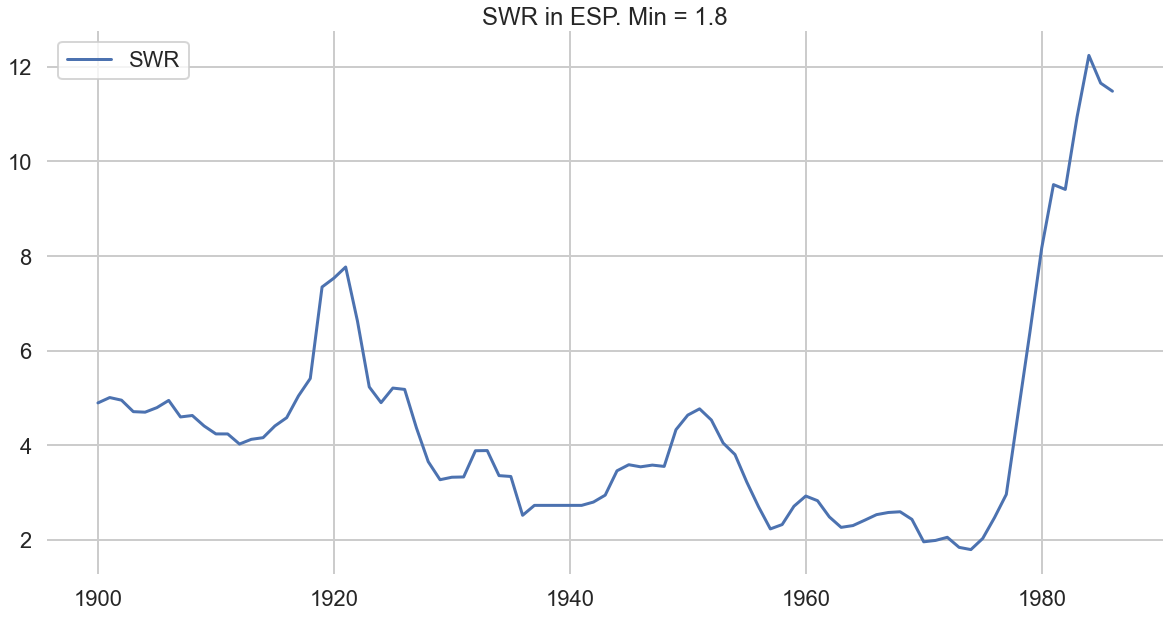

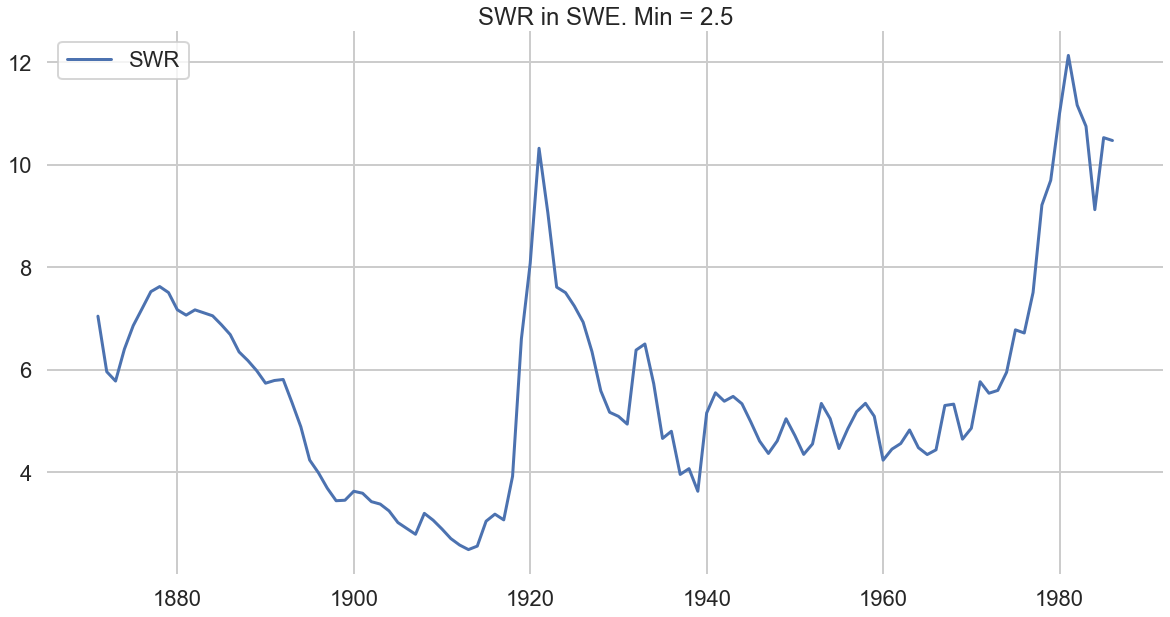

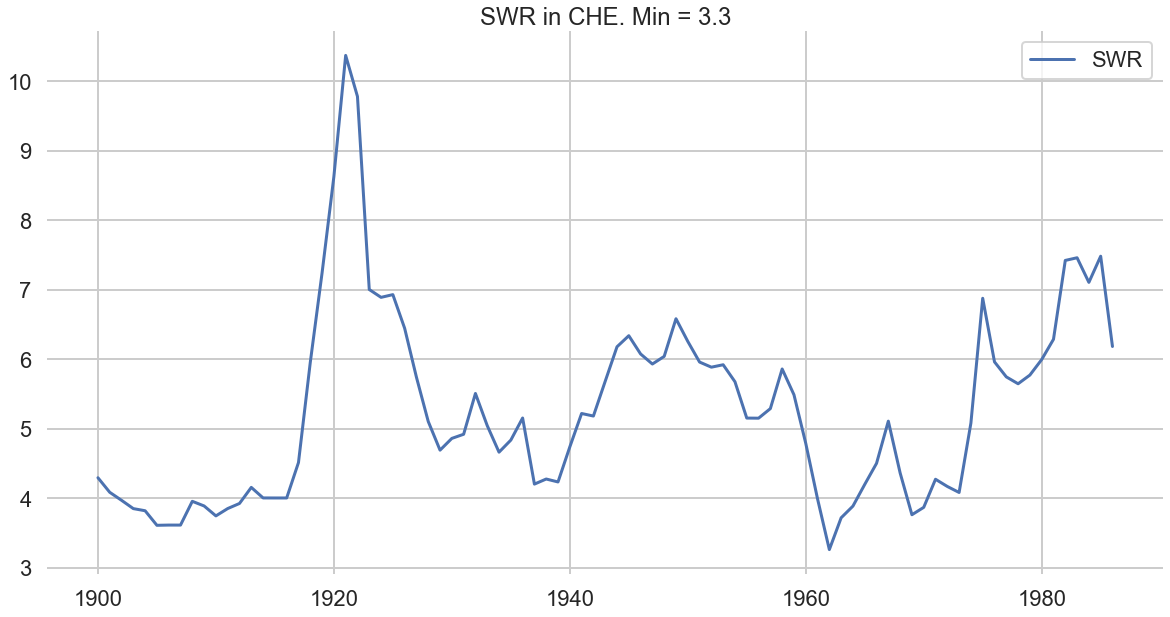

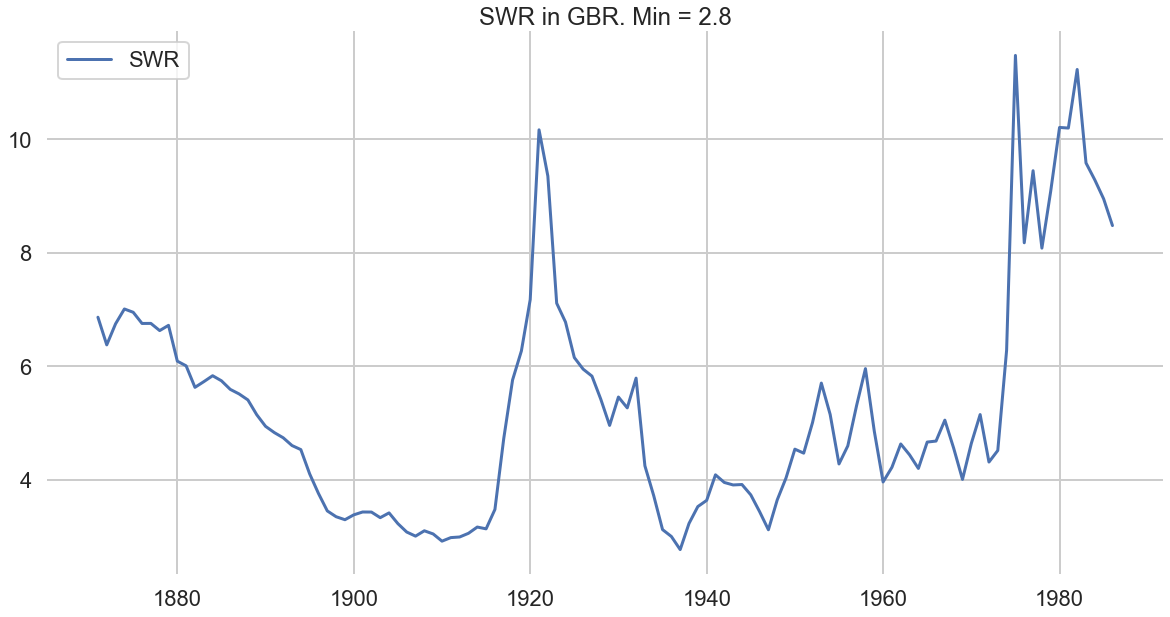

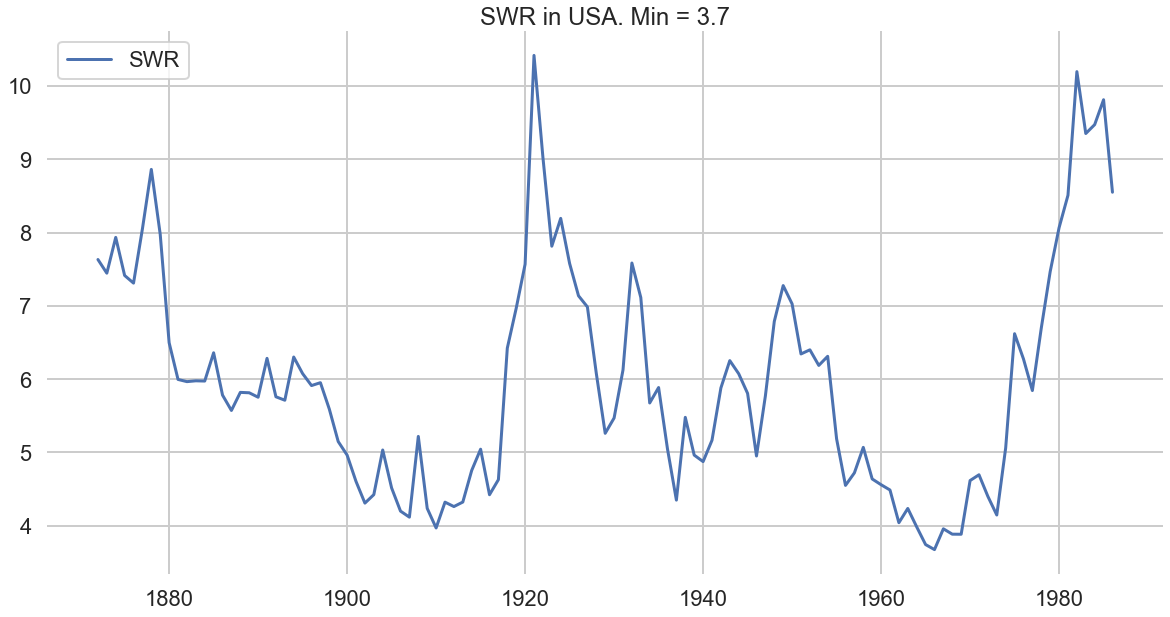

In [5]:
for country in market.JST.Countries:
    if country == 'CAN': continue
    m = market.JST(country)
    swrs = run(m)
    df = pandas.DataFrame(swrs, columns=['SWR'])
    plot(df, country)

In [6]:
MSWRS = pandas.Series(index=market.JST.Countries)

for country in market.JST.Countries:
    if country == 'CAN': continue
    m = market.JST(country)
    m.start_year = 1950
    swrs = run(m)
    mswr = swrs.min()
    MSWRS.loc[country] = mswr

/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [7]:
MSWRS.sort_values(ascending=False)

JPN    4.606674
SWE    4.239777
DNK    4.040959
DEU    4.035451
GBR    3.961606
FIN    3.838599
USA    3.672566
NLD    3.414688
BEL    3.320302
AUS    3.298490
CHE    3.260336
NOR    2.775738
FRA    1.822675
ESP    1.794782
ITA    1.753334
PRT    0.509965
CAN         NaN
dtype: float64

In [8]:
df = pandas.read_stata('JSTdatasetR4.dta')
df['year'] = df['year'].astype(int)
df.head()

,year,country,iso,ifs,pop,rgdpmad,rgdppc,rconpc,gdp,iy,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
0,1870,Australia,AUS,193,1775.0,3273.239437,13.836157,21.449734,208.78,0.109266,...,-0.070045,0.071417,NaN,NaN,NaN,0.049118,0.066415,NaN,NaN,NaN
1,1871,Australia,AUS,193,1675.0,3298.507463,13.936864,19.930801,211.56,0.104579,...,0.041654,0.065466,NaN,NaN,NaN,0.048446,0.068193,NaN,NaN,NaN
2,1872,Australia,AUS,193,1722.0,3553.426249,15.044247,21.085006,227.40,0.130438,...,0.108945,0.062997,NaN,NaN,NaN,0.047373,0.069861,NaN,NaN,NaN
3,1873,Australia,AUS,193,1769.0,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.083086,0.064484,NaN,NaN,NaN,0.046720,0.069842,NaN,NaN,NaN
4,1874,Australia,AUS,193,1822.0,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.119389,0.063503,NaN,NaN,NaN,0.046533,0.071085,NaN,NaN,NaN


In [9]:
usa = df[df['country'] == 'USA']
usa.index = usa['year']
usa['risky_tr']

year
1870         NaN
1871         NaN
1872         NaN
1873         NaN
1874         NaN
          ...   
2012    0.105332
2013    0.212405
2014    0.132729
2015    0.065433
2016         NaN
Name: risky_tr, Length: 147, dtype: float32

In [10]:
c = df[df['country'] == 'France']
c.index = c['year']
carry = c['xrusd'] / c['xrusd'].shift(1)
new_df = pandas.DataFrame({'equities': usa['eq_tr'], 'carry': carry})
tr = new_df.sum(axis=1)
inflation = c['cpi'] / c['cpi'].shift(1)

real_return = (tr / inflation) - 1

In [11]:
f = []
for i in range (1, len(real_return) - 30):
    ssr = metrics.pwa(100, 0, real_return[i:i+30].tolist())
    f.append(ssr)
min(f)

3.2425682663707707

Text(0.5, 1.0, 'Japan 60/40 3.3% rule portfolio values')

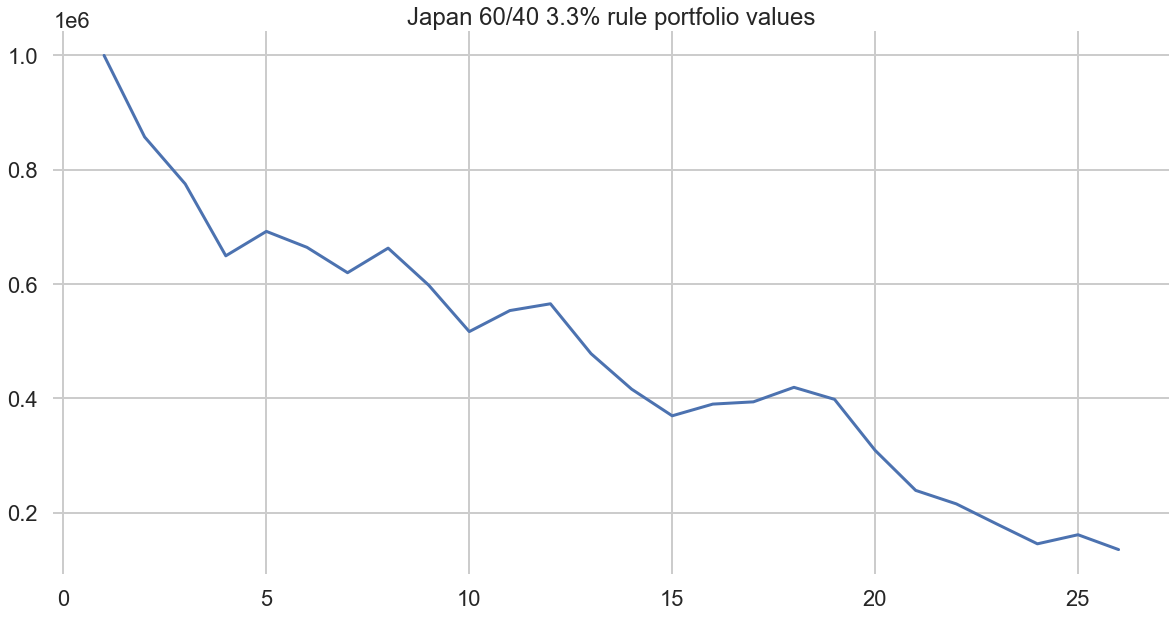

In [25]:
s = simulate.withdrawals(market.JST('JPN').iter_from(1990),
                     years=30,
                     harvesting=harvesting.N_60_RebalanceHarvesting,
                     withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=D('.033'))
)

plt.figure(figsize=(20,10))
ax = seaborn.lineplot(
                data=pandas.Series(index=range(1,len(s)+1), data=[int(x.portfolio_pre.value_r) for x in s])
               )
seaborn.despine(ax=ax, left=True, bottom=True, offset=20)
ax.set_title(f'Japan 60/40 3.3% rule portfolio values')

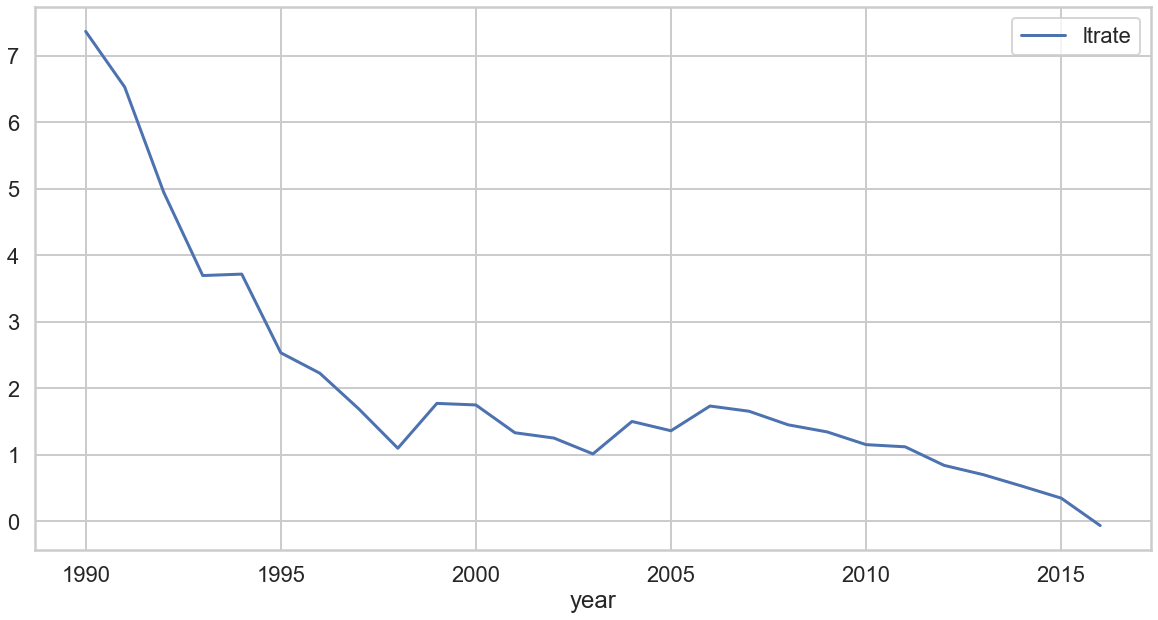

In [58]:
df = pandas.read_stata('JSTdatasetR4.dta')
df['year'] = df['year'].astype(int)
df = df[df['iso'] == 'JPN']
df.index = df['year']
crash = df[df['year']>=1990]
crash = crash[['ltrate']]
#crash = crash[['eq_capgain', 'eq_dp']]
crash.head()
plt.figure(figsize=(20,10))
seaborn.lineplot(data=crash)